# Advanced Lane Finding
---
---

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

---

## Calibrate a camera

### Run the code in the cell below to extract object points and image points for camera calibration.

In [1]:
import numpy as np
import cv2
import glob
import os
import pickle
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline


def calibrate_camera():
    
    if (os.path.isfile('pickles/calibration_pickle.p')):
        # Loading camera calibration pickle
        cameraCalibration = pickle.load( open('pickles/calibration_pickle.p', 'rb' ) )
        mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))
    else:
        
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        # Make a list of calibration images
        images = glob.glob('camera_cal/calibration*.jpg')

        ### Plot images after finding corners
        fig = plt.figure(figsize=(15, 10))

        # Step through the list and search for chessboard corners
        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)

                # Draw and display the corners
                cv2.drawChessboardCorners(img, (9,6), corners, ret)
                write_name = 'camera_cal/corners/calibration' + str(idx+1) +'.jpg'
                cv2.imwrite(write_name, img)
                cv2.imshow('img', img)
                cv2.waitKey(500)
                plt.subplot(5, 4, idx+1)
                plt.imshow(img)
                plt.title('calibration' + str(idx+1) +'.jpg')
                plt.axis('off')

        cv2.destroyAllWindows()

        fig.subplots_adjust(wspace=0.1, hspace=0.2)

        plt.show()
        
        img_size = (img.shape[1], img.shape[0])

        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

        # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump( dist_pickle, open( "pickles/calibration_pickle.p", "wb" ) )
    
    return mtx, dist

In [2]:
calibrate_camera()

(array([[  1.15396093e+03,   0.00000000e+00,   6.69705359e+02],
        [  0.00000000e+00,   1.14802495e+03,   3.85656232e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]),
 array([[ -2.41017968e-01,  -5.30720497e-02,  -1.15810318e-03,
          -1.28318543e-04,   2.67124302e-02]]))

### If the above cell ran sucessfully, you should now have objpoints and imgpoints needed for camera calibration. Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

(-0.5, 1279.5, 719.5, -0.5)

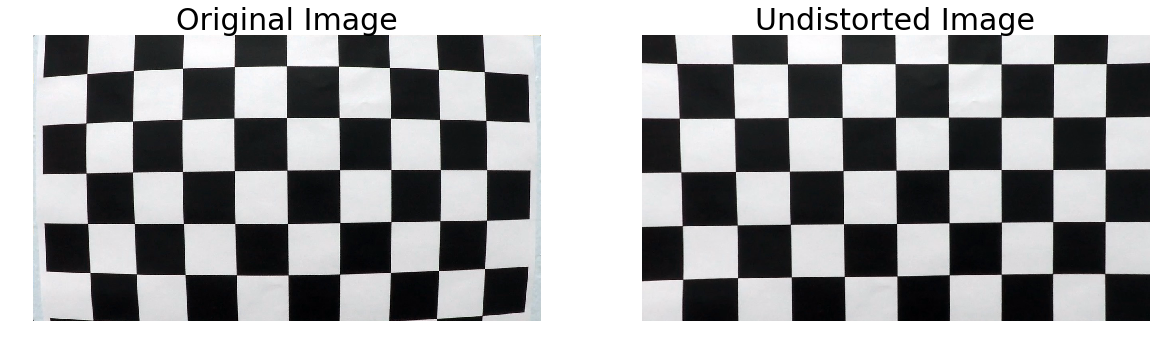

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Get camera calibration
mtx, dist = calibrate_camera()


undist = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/undist/calibration1.jpg',undist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
ax2.axis('off')


---
## 2. Apply a distortion correction to raw images.
---

## Undistort Image

In [4]:
# undistort image using camera calibration matrix and distortion coefficients from above
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

### Apply undistort to a test image

(-0.5, 1279.5, 719.5, -0.5)

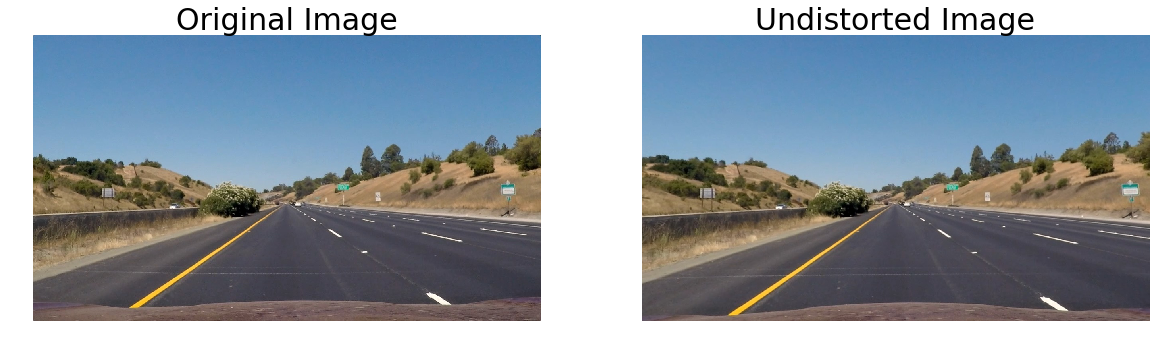

In [5]:
# Get camera calibration
mtx, dist = calibrate_camera()

# Test undistortion on an image
img = cv2.imread('test_images/straight_lines1.jpg')

undist = undistort(img, mtx, dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')
ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)
ax2.axis('off')

---
## 3. Use color transforms, gradients, etc., to create a thresholded binary image.
---

In [6]:
def grayscale(img):
    """
    Applies the Grayscale transform
    """
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255), togray = False):    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return grad_binary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255), togray = False):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return mag_binary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2), togray = False):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return dir_binary

In [7]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [8]:
# Edit this function to create your own pipeline.
def color_grad_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # grayscale
    gray = grayscale(img)
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Threshold color channel
    s_binary = hls_select(img, thresh=(170, 255))
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(combined), combined, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1

    return combined_binary

In [9]:
# Edit this function to create your own pipeline.
def color_grad_pipeline_hls(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

### Apply color transform and gradient to test image

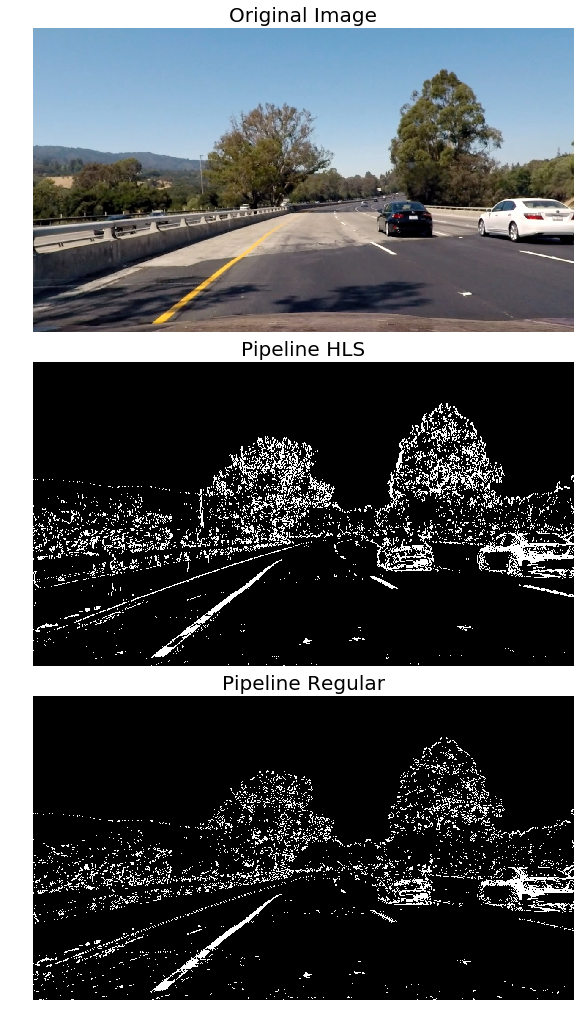

In [10]:
# Get camera calibration
mtx, dist = calibrate_camera()

# Test undistortion on an image
img = cv2.imread('test_images/test4.jpg')

undist = undistort(img, mtx, dist)

result = color_grad_pipeline_hls(undist)

result1 = color_grad_pipeline(undist)

# Plot the result
f, axes = plt.subplots(3, 1, figsize=(24, 15))
f.tight_layout()

axes[0].imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image', fontsize=20)
axes[0].axis('off')

axes[1].imshow(result, cmap='gray')
axes[1].set_title('Pipeline HLS', fontsize=20)
axes[1].axis('off')

axes[2].imshow(result1, cmap='gray')
axes[2].set_title('Pipeline Regular', fontsize=20)
axes[2].axis('off')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [11]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)   
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)  
    
    return masked_image


---
## 4. Apply a perspective transform to rectify binary image ("birds-eye view").
---

In [12]:
from skimage import exposure

def perspective_transform(img):
    #define perspective transform area
    img_size = (img.shape[1], img.shape[0])    
    #src = np.float32([[0.489*img.shape[1],0.597*img.shape[0]],[0.508*img.shape[1],0.597*img.shape[0]],[0.815*img.shape[1],0.944*img.shape[0]],[0.203*img.shape[1],0.944*img.shape[0]]])

    #src = np.float32([[0.46*img.shape[1],0.62*img.shape[0]],[0.54*img.shape[1],0.62*img.shape[0]],[0.88*img.shape[1],0.935*img.shape[0]],[0.12*img.shape[1],0.935*img.shape[0]]])

    src = np.float32([[0.455*img.shape[1],0.639*img.shape[0]],[0.547*img.shape[1],0.639*img.shape[0]],[0.815*img.shape[1],0.944*img.shape[0]],[0.203*img.shape[1],0.944*img.shape[0]]])

    offset = img_size[0]*.28
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
    M = []
    Minv = []
    
    if (not os.path.isfile('pickles/perspective_pickle.p')):
        # perform the transform
        # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        pickle.dump((M, Minv), open('pickles/perspective_pickle.p', "wb"))
    else:
        (M, Minv) = pickle.load(open('pickles/perspective_pickle.p', "rb"))
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    #warped = exposure.rescale_intensity(warped, out_range = (0, 255))
    
    return src,dst,M,Minv,warped

### Apply perspective transform to test image

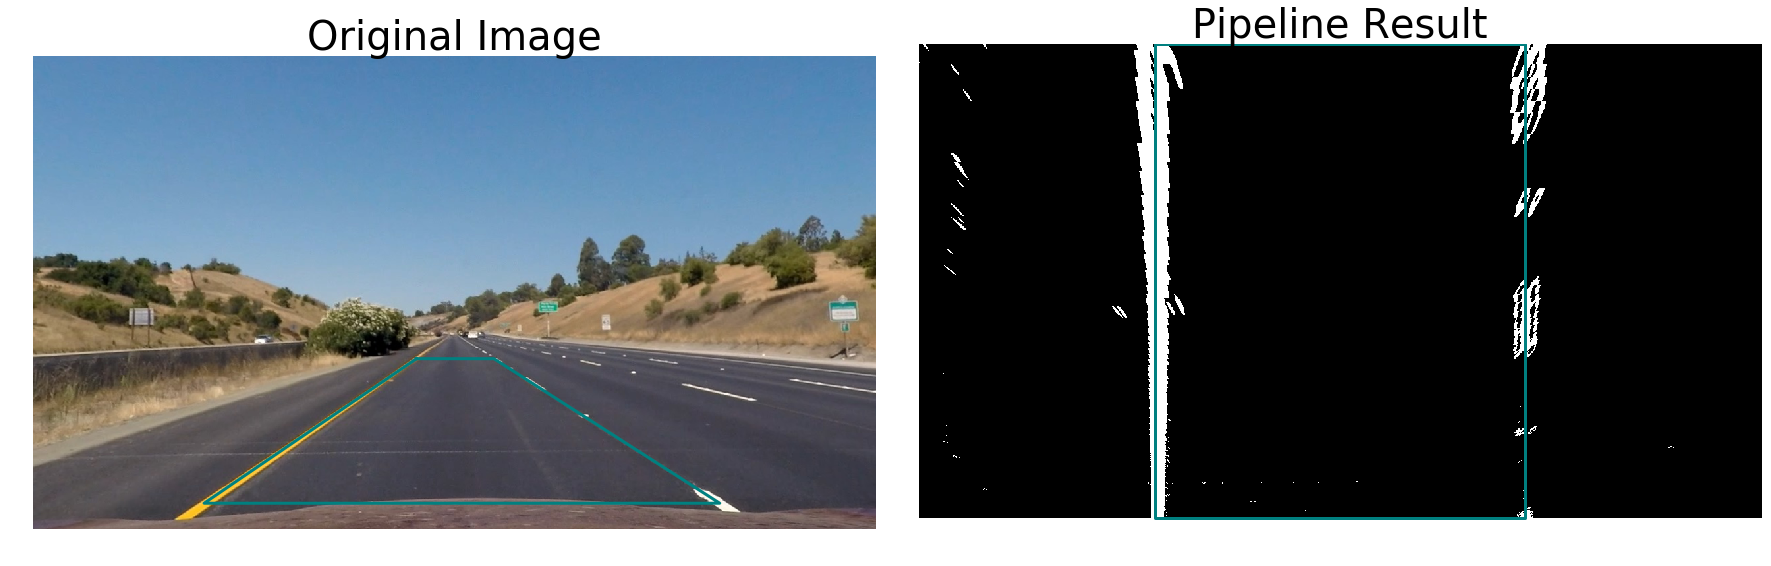

In [13]:
# Get camera calibration
mtx, dist = calibrate_camera()

# Test undistortion on an image
img = cv2.imread('test_images/straight_lines1.jpg')

undist = undistort(img, mtx, dist)

result = color_grad_pipeline_hls(undist)

src,dst,M,Minv,warped = perspective_transform(result)

# Plot the result
f, axes = plt.subplots(1, 2, figsize=(24, 15))
f.tight_layout()

axes[0].imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image', fontsize=40)
x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
axes[0].plot(x, y, color='teal', linewidth=3)
axes[0].set_ylim([img.shape[0],0])
axes[0].set_xlim([0,img.shape[1]])
axes[0].axis('off')

#axes[1].imshow(cv2.cvtColor(transformed1, cv2.COLOR_BGR2RGB))
axes[1].imshow(warped, cmap='gray')
x = [dst[0][0],dst[1][0],dst[2][0],dst[3][0],dst[0][0]]
y = [dst[0][1],dst[1][1],dst[2][1],dst[3][1],dst[0][1]]
axes[1].plot(x, y, color='teal', linewidth=3)
axes[1].set_title('Pipeline Result', fontsize=40)
axes[1].axis('off')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
## 5. Detect lane pixels and fit to find the lane boundary.
---

In [14]:
def get_fit(leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)   
    
    return left_fit, right_fit

In [15]:
def fit_poly(img_shape, left_fit, right_fit):    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [16]:
def find_lane_pixels(binary_warped, visualize_on = False):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if visualize_on:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if visualize_on:
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
    
    if visualize_on:
        return leftx, lefty, rightx, righty, out_img 
    else:
        return leftx, lefty, rightx, righty

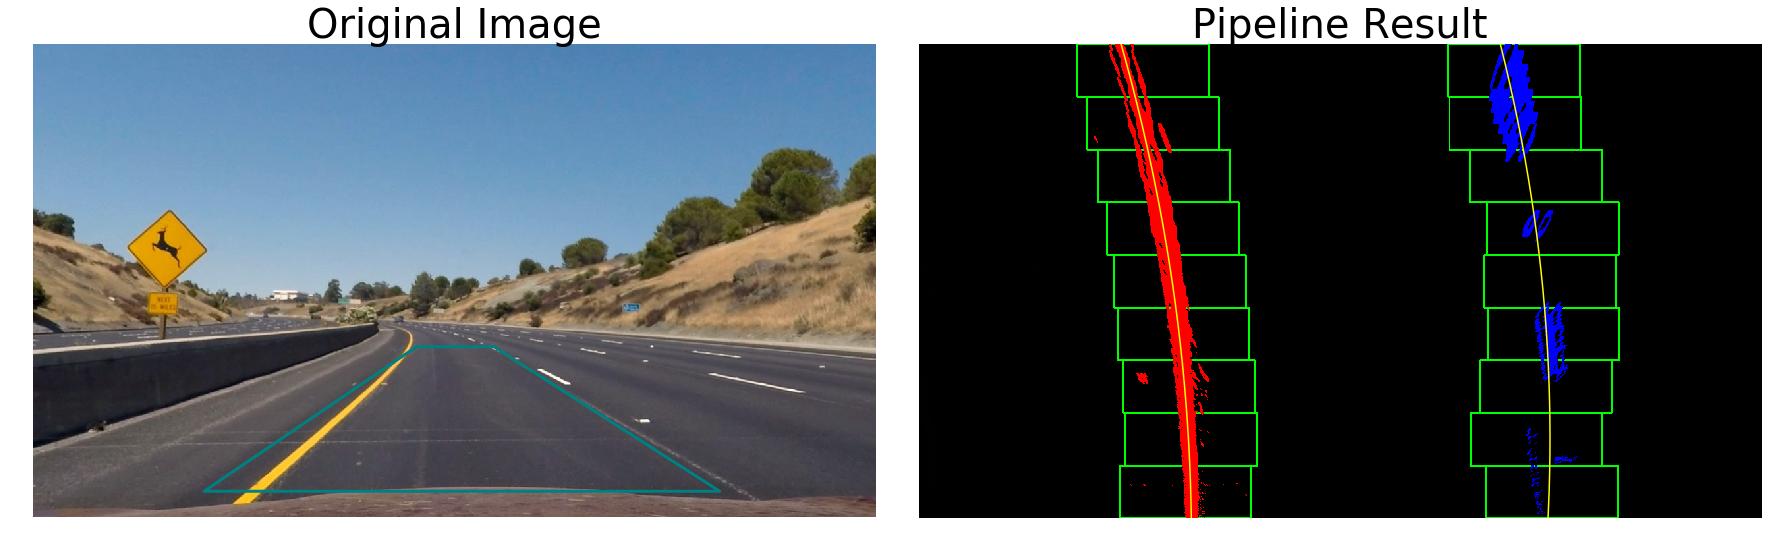

In [17]:
# Get camera calibration
mtx, dist = calibrate_camera()

# Test undistortion on an image
img = cv2.imread('test_images/test2.jpg')

undist = undistort(img, mtx, dist)

result = color_grad_pipeline_hls(undist)

src,dst,M,Minv,binary_warped = perspective_transform(result)

leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, visualize_on = True)

left_fit, right_fit = get_fit(leftx, lefty, rightx, righty)

# Fit new polynomials
left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, left_fit, right_fit)

# Plot the result
f, axes = plt.subplots(1, 2, figsize=(24, 15))
f.tight_layout()

axes[0].imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image', fontsize=40)
x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
axes[0].plot(x, y, color='teal', linewidth=3)
axes[0].set_ylim([img.shape[0],0])
axes[0].set_xlim([0,img.shape[1]])
axes[0].axis('off')

axes[1].imshow(out_img, cmap='gray')
# Plot the polynomial lines onto the image
axes[1].plot(left_fitx, ploty, color='yellow')
axes[1].plot(right_fitx, ploty, color='yellow')
axes[1].set_title('Pipeline Result', fontsize=40)
axes[1].axis('off')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [18]:
def search_around_poly(binary_warped, left_fit, right_fit, visualize_on = False):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]    
    
    if visualize_on:
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        ## End visualization steps ##    
    
    if visualize_on:
        return leftx, lefty, rightx, righty, result 
    else:
        return leftx, lefty, rightx, righty

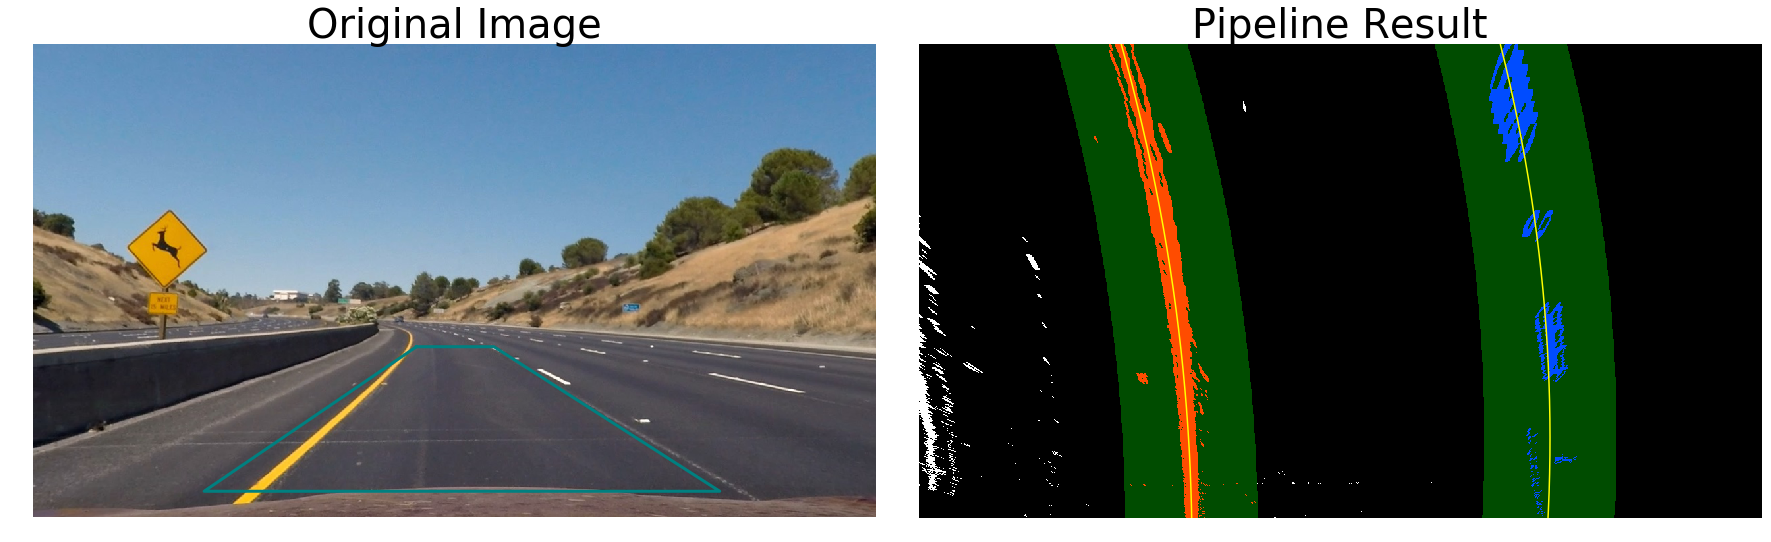

In [19]:
# Get camera calibration
mtx, dist = calibrate_camera()

# Test undistortion on an image
img = cv2.imread('test_images/test2.jpg')

undist = undistort(img, mtx, dist)

result = color_grad_pipeline_hls(undist)

src,dst,M,Minv,binary_warped = perspective_transform(result)

leftx, lefty, rightx, righty, out_img = search_around_poly(binary_warped, left_fit, right_fit, visualize_on = True)

left_fit, right_fit = get_fit(leftx, lefty, rightx, righty)

# Fit new polynomials
left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, left_fit, right_fit)

# Plot the result
f, axes = plt.subplots(1, 2, figsize=(24, 15))
f.tight_layout()

axes[0].imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image', fontsize=40)
x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
axes[0].plot(x, y, color='teal', linewidth=3)
axes[0].set_ylim([img.shape[0],0])
axes[0].set_xlim([0,img.shape[1]])
axes[0].axis('off')

axes[1].imshow(out_img, cmap='gray')
# Plot the polynomial lines onto the image
axes[1].plot(left_fitx, ploty, color='yellow')
axes[1].plot(right_fitx, ploty, color='yellow')
axes[1].set_title('Pipeline Result', fontsize=40)
axes[1].axis('off')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [20]:
def get_curvature_position(image_shape, leftx, lefty, rightx, righty, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    is_good_lane = True
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit a second order polynomial to pixel positions
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    if left_curverad <= 500.0 or right_curverad <= 500.0:
        is_good_lane = False
        
    # Get Poly coeffs
    left_fit, right_fit = get_fit(leftx, lefty, rightx, righty)
    
    
    # Calculate vehicle center
    yMax = img.shape[0]*ym_per_pix
    line_left = left_fit_cr[0]*yMax**2 + left_fit_cr[1]*yMax + left_fit_cr[2]
    line_right = right_fit_cr[0]*yMax**2 + right_fit_cr[1]*yMax + right_fit_cr[2]
    line_width = line_right - line_left
    #print(line_width)
    if abs(3.7 - line_width) > 1.2:
        is_good_lane = False
    
    # Calculate the offset of the car on the road
    camera_center = img.shape[1]*xm_per_pix/2
    left_position_from_center = abs(camera_center - line_left)
    right_position_from_center = abs(camera_center - line_right) 
    
    return left_curverad, right_curverad, left_position_from_center, right_position_from_center,is_good_lane

In [21]:
def draw_lanes(Minv,undist,binary_warped,ploty, left_fitx, right_fitx):
    image_shape = binary_warped.shape
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp_bkg = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(0,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(color_warp_bkg, np.int32([pts_left]), isClosed=False, color=(255,255,255), thickness=15)
    cv2.polylines(color_warp_bkg, np.int32([pts_right]), isClosed=False, color=(255,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_shape[1], image_shape[0]))
    newwarp_bkg = cv2.warpPerspective(color_warp_bkg, Minv, (image_shape[1], image_shape[0])) 
    # Combine the result with the original image
    base = cv2.addWeighted(undist, 1, newwarp_bkg, -0.5, 0)
    final_result = cv2.addWeighted(base, 1, newwarp, 1, 0)
    
    return final_result

In [22]:
def draw_metrics(final_image, left_curverad, right_curverad, left_position_from_center, right_position_from_center):
    # Calculation of R_curve (radius of curvature)
    curverad = (left_curverad + right_curverad)/2
    curverad = str(round(curverad,3)) + 'm'
    # Calculate the offset of the car on the road
    lane_center = (left_position_from_center + right_position_from_center)/2
    distance_from_center = lane_center - left_position_from_center
    position_from_center = str(abs(round(distance_from_center,3))) + 'm ' + 'left'
    if distance_from_center <= 0:
        position_from_center = str(abs(round(distance_from_center,3))) + 'm ' + 'right'
        
    # draw the text showing curvature, offset and speed
    cv2.putText(final_image,'Radius of Curvature = ' + curverad,(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(final_image,'Vehicle is ' + position_from_center + ' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    return final_image

In [23]:
def draw_line_data(final_image,left_line,right_line):
     
    #cv2.putText(final_image,'Best fit = ' + str(np.around(left_line.best_fit,2)) +'|' + str(right_line.best_fit),(50,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    #cv2.putText(final_image,'Current fit = ' + str(np.around(left_line.current_fit[-1],2)) +'|' + str(right_line.current_fit[-1]), (50,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(final_image,'Left Radius = ' + str(round(left_line.radius_of_curvature,3)) + 'm',(50,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(final_image,'Right Radius = ' + str(round(right_line.radius_of_curvature,3)) + 'm', (50,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    return final_image

In [34]:
def render_pip(original,sub):
    image_size =  original.shape
    resized_image = cv2.resize(sub, (0,0), fx=0.35, fy=0.35)
    image_size_new = resized_image.shape
    #set top left position of the resized image
    pip_h = 800
    pip_w = 10
    original[pip_h:pip_h+image_size_new[0],pip_w:pip_w+image_size_new[1]] = resized_image  # make it PIP
    return original

In [25]:
def pipeline(img, left_line = None, right_line = None, videoMode = False, diagnostic_mode = False):
    
    # Get camera calibration
    mtx, dist = calibrate_camera()
    
    # undistort image
    undist = undistort(img, mtx, dist)
    
    # color transform
    result = color_grad_pipeline_hls(undist)
    
    # calculate vertices for polygon to be used in ROI
    image_shape = img.shape
    image_vertices = np.array([[(0.1*image_shape[1],image_shape[0]),
                          (0.95*image_shape[1],image_shape[0]),
                          (0.54*image_shape[1],0.61*image_shape[0]),
                          (0.46*image_shape[1],0.61*image_shape[0])]],
                        dtype=np.int32)
    # Apply region mask
    image_masked = region_of_interest(result, image_vertices)
    
    # Perspective transform
    src,dst,M,Minv,binary_warped = perspective_transform(image_masked)
    
    if videoMode == True and not left_line == None and not right_line == None:
        if not left_line.detected or not right_line.detected:
            print('orig')
            leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, visualize_on = True)
        else:
            print('search')
            leftx, lefty, rightx, righty, out_img = search_around_poly(binary_warped, left_line.current_fit[-1], right_line.current_fit[-1], visualize_on = True)
            print(len(leftx))
    else:
        print('image')
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, visualize_on = True)
    
    # Get Poly coeffs
    left_fit, right_fit = get_fit(leftx, lefty, rightx, righty)

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, left_fit, right_fit)
    
    # Calculate the offset of the car on the road
    left_curverad, right_curverad, left_position_from_center, right_position_from_center, is_good_lane = get_curvature_position(image_shape, leftx, lefty, rightx, righty, ploty)
    
    if videoMode:
        if is_good_lane or left_line.best_fit == None:
            print('left good')
            left_line.add(left_fit,left_fitx,leftx,lefty,left_curverad, left_position_from_center)
        else:
            print('left not good')
            left_line.detected = False
        
        if is_good_lane or right_line.best_fit == None:
            print('right good')
            right_line.add(right_fit,right_fitx,rightx,righty,right_curverad, right_position_from_center)
        else:
            print('right not good')
            right_line.detected = False
        
        # draw lanes onto image
        final_result = draw_lanes(Minv,undist,binary_warped,ploty, left_line.bestx, right_line.bestx)

        # draw metrics onto image
        final_image = draw_metrics(final_result,left_line.radius_of_curvature,right_line.radius_of_curvature,left_line.line_base_pos,right_line.line_base_pos)
        
        if diagnostic_mode:
            final_image = draw_line_data(final_image,left_line,right_line)
            final_image = render_pip(final_image,out_img)
        
        return final_image
    else:        
    
        # draw lanes onto image
        final_result = draw_lanes(Minv,undist,binary_warped,ploty, left_fitx, right_fitx)

        # draw metrics onto image
        final_image = draw_metrics(final_result,left_curverad, right_curverad, left_position_from_center, right_position_from_center)

        return final_image,out_img,left_fitx,right_fitx

image
image
image
image
image
image


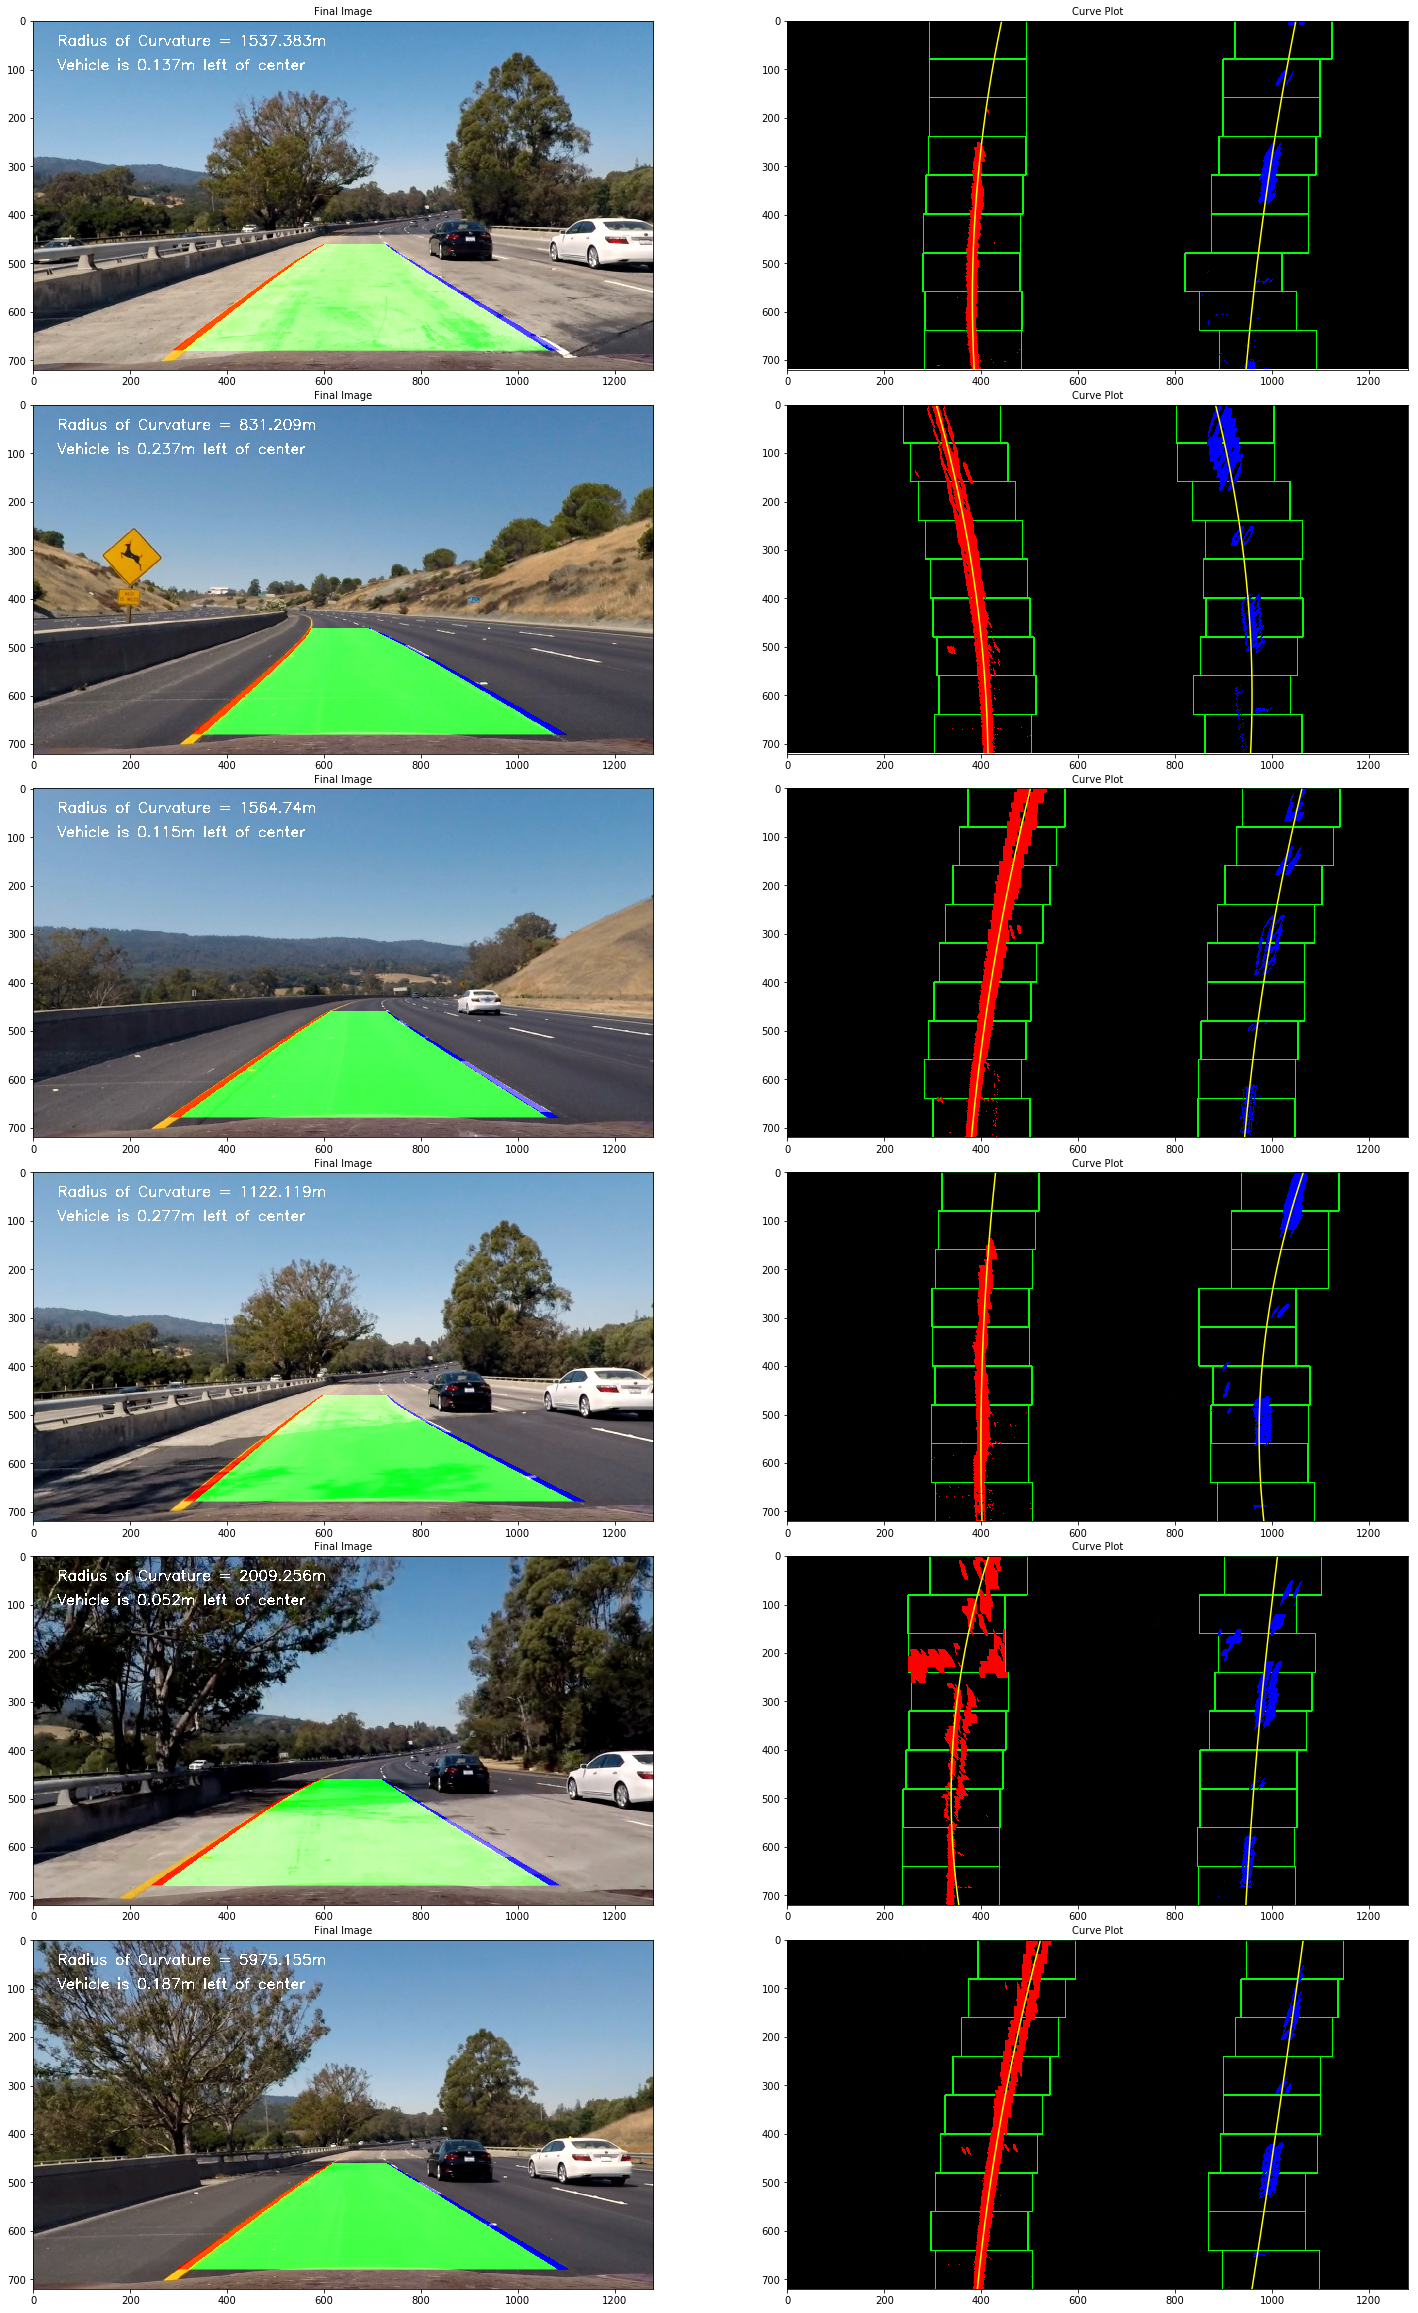

In [26]:
# Make a list of calibration images
images = glob.glob('test_images/test*.jpg')

f, axes = plt.subplots(6, 2, figsize=(20, 35))
f.tight_layout()

for idx, fname in enumerate(images):
    # Test undistortion on an image
    img = cv2.imread(fname)
    
    final_result,out_img,left_fitx,right_fitx = pipeline(img)
    
    # Plot the result    

    axes[idx,0].imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
    axes[idx,0].set_title('Final Image', fontsize=10)

    axes[idx,1].imshow(out_img, cmap='gray')
    axes[idx,1].plot(left_fitx, ploty, color='yellow')
    axes[idx,1].plot(right_fitx, ploty, color='yellow')
    axes[idx,1].set_title('Curve Plot', fontsize=10)
    axes[idx,1].set_ylim([img.shape[0],0])
    axes[idx,1].set_xlim([0,img.shape[1]])   
    

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.,wspace=0.1, hspace=0.1)

In [27]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    def add(self, fit, fitx, x, y, rad, pos):
        if self.best_fit is not None:
            self.diffs = abs(fit-self.best_fit)
        if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
        else:
            self.detected = True

            self.recent_xfitted.append(fitx)
            #only keep the n most recent fitx
            if len(self.recent_xfitted) >= 10:
                self.recent_xfitted.pop(0)
            #take the average of the past and the new fitx
            if len(self.recent_xfitted) > 0:
                self.bestx = np.average(self.recent_xfitted, axis=0)
            self.current_fit.append(fit)
            #only keep the n most recent fit
            if len(self.current_fit) >= 10:
                self.current_fit.pop(0)
            #take the average of the past and the new fit
            if len(self.current_fit) > 0:
                self.best_fit = np.average(self.current_fit, axis=0)
            self.radius_of_curvature = rad
            self.line_base_pos = pos
            self.allx = x
            self.ally = y
        
        
        


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [29]:
def process_image(image, left_line, right_line):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    return pipeline(image, left_line, right_line, True, True)

[ -8.23773375e-05   8.91863601e-02   1.62996323e+02]
[  1.04372904e-04  -1.19975461e-01   5.04195344e+02]


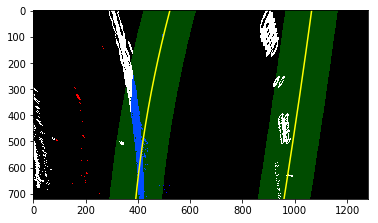

In [39]:
print(left_line.best_fit)
print(right_line.best_fit)
leftx, lefty, rightx, righty, out_img = search_around_poly(binary_warped, left_line.best_fit, right_line.best_fit, visualize_on = True)
plt.imshow(out_img, cmap='gray')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

In [35]:
left_line = Line()
right_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4').subclip(22,26)
processed_video = video_input1.fl_image(lambda image: process_image(image, left_line, right_line))
%time processed_video.write_videofile(video_output1, audio=False)
video_input1.close()

orig
left good
right good
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|                                                                                          | 0/101 [00:00<?, ?it/s]

search
11370
left good
right good


  1%|▊                                                                                 | 1/101 [00:00<00:47,  2.12it/s]

orig
left good
right good


  2%|█▌                                                                                | 2/101 [00:00<00:33,  2.99it/s]

orig
left good
right good


  3%|██▍                                                                               | 3/101 [00:00<00:28,  3.48it/s]

orig
left good
right good


  4%|███▏                                                                              | 4/101 [00:01<00:26,  3.65it/s]

orig
left good
right good


  5%|████                                                                              | 5/101 [00:01<00:24,  3.84it/s]

orig
left good
right good


  6%|████▊                                                                             | 6/101 [00:01<00:23,  4.06it/s]

orig
left good
right good


  7%|█████▋                                                                            | 7/101 [00:01<00:22,  4.10it/s]

orig
left good
right good


  8%|██████▍                                                                           | 8/101 [00:01<00:21,  4.24it/s]

orig
left good
right good


  9%|███████▎                                                                          | 9/101 [00:02<00:21,  4.33it/s]

orig
left good
right good


 10%|████████                                                                         | 10/101 [00:02<00:20,  4.40it/s]

orig
left good
right good


 11%|████████▊                                                                        | 11/101 [00:02<00:20,  4.48it/s]

orig
left good
right good


 12%|█████████▌                                                                       | 12/101 [00:02<00:19,  4.53it/s]

orig
left good
right good


 13%|██████████▍                                                                      | 13/101 [00:02<00:19,  4.56it/s]

orig
left good
right good


 14%|███████████▏                                                                     | 14/101 [00:03<00:19,  4.56it/s]

orig
left good
right good


 15%|████████████                                                                     | 15/101 [00:03<00:18,  4.59it/s]

orig
left good
right good


 16%|████████████▊                                                                    | 16/101 [00:03<00:18,  4.55it/s]

orig
left good
right good


 17%|█████████████▋                                                                   | 17/101 [00:03<00:18,  4.57it/s]

orig
left good
right good


 18%|██████████████▍                                                                  | 18/101 [00:03<00:18,  4.55it/s]

orig
left good
right good


 19%|███████████████▏                                                                 | 19/101 [00:04<00:17,  4.56it/s]

orig
left good
right good


 20%|████████████████                                                                 | 20/101 [00:04<00:17,  4.54it/s]

orig
left good
right good


 21%|████████████████▊                                                                | 21/101 [00:04<00:17,  4.49it/s]

orig
left good
right good


 22%|█████████████████▋                                                               | 22/101 [00:04<00:17,  4.48it/s]

orig
left good
right good


 23%|██████████████████▍                                                              | 23/101 [00:05<00:17,  4.40it/s]

orig
left good
right good


 24%|███████████████████▏                                                             | 24/101 [00:05<00:17,  4.40it/s]

orig
left good
right good


 25%|████████████████████                                                             | 25/101 [00:05<00:17,  4.42it/s]

orig
left good
right good


 26%|████████████████████▊                                                            | 26/101 [00:05<00:16,  4.45it/s]

orig
left good
right good


 27%|█████████████████████▋                                                           | 27/101 [00:06<00:16,  4.45it/s]

orig
left good
right good


 28%|██████████████████████▍                                                          | 28/101 [00:06<00:16,  4.43it/s]

orig
left good
right good


 29%|███████████████████████▎                                                         | 29/101 [00:06<00:16,  4.44it/s]

orig
left good
right good


 30%|████████████████████████                                                         | 30/101 [00:06<00:15,  4.45it/s]

orig
left good
right good


 31%|████████████████████████▊                                                        | 31/101 [00:06<00:15,  4.48it/s]

orig
left not good
right not good


 32%|█████████████████████████▋                                                       | 32/101 [00:07<00:15,  4.51it/s]

orig
left good
right good


 33%|██████████████████████████▍                                                      | 33/101 [00:07<00:14,  4.54it/s]

orig
left good
right good


 34%|███████████████████████████▎                                                     | 34/101 [00:07<00:14,  4.55it/s]

orig
left good
right good


 35%|████████████████████████████                                                     | 35/101 [00:07<00:14,  4.55it/s]

orig
left good
right good


 36%|████████████████████████████▊                                                    | 36/101 [00:07<00:14,  4.56it/s]

orig
left good
right good


 37%|█████████████████████████████▋                                                   | 37/101 [00:08<00:14,  4.56it/s]

orig
left good
right good


 38%|██████████████████████████████▍                                                  | 38/101 [00:08<00:13,  4.57it/s]

orig
left good
right good


 39%|███████████████████████████████▎                                                 | 39/101 [00:08<00:13,  4.57it/s]

orig
left good
right good


 40%|████████████████████████████████                                                 | 40/101 [00:08<00:13,  4.58it/s]

orig
left good
right good


 41%|████████████████████████████████▉                                                | 41/101 [00:08<00:13,  4.58it/s]

orig
left good
right good


 42%|█████████████████████████████████▋                                               | 42/101 [00:09<00:12,  4.58it/s]

orig
left good
right good


 43%|██████████████████████████████████▍                                              | 43/101 [00:09<00:12,  4.54it/s]

orig
left good
right good


 44%|███████████████████████████████████▎                                             | 44/101 [00:09<00:12,  4.51it/s]

orig
left good
right good


 45%|████████████████████████████████████                                             | 45/101 [00:09<00:12,  4.50it/s]

orig
left not good
right not good


 46%|████████████████████████████████████▉                                            | 46/101 [00:10<00:12,  4.51it/s]

orig
left good
right good


 47%|█████████████████████████████████████▋                                           | 47/101 [00:10<00:11,  4.52it/s]

orig
left not good
right not good


 48%|██████████████████████████████████████▍                                          | 48/101 [00:10<00:11,  4.52it/s]

orig
left good
right good


 49%|███████████████████████████████████████▎                                         | 49/101 [00:10<00:11,  4.51it/s]

orig
left good
right good


 50%|████████████████████████████████████████                                         | 50/101 [00:11<00:11,  4.51it/s]

orig
left good
right good


 50%|████████████████████████████████████████▉                                        | 51/101 [00:11<00:11,  4.52it/s]

orig
left good
right good


 51%|█████████████████████████████████████████▋                                       | 52/101 [00:11<00:10,  4.50it/s]

orig
left good
right good


 52%|██████████████████████████████████████████▌                                      | 53/101 [00:11<00:10,  4.50it/s]

orig
left good
right good


 53%|███████████████████████████████████████████▎                                     | 54/101 [00:12<00:10,  4.50it/s]

orig
left good
right good


 54%|████████████████████████████████████████████                                     | 55/101 [00:12<00:10,  4.49it/s]

orig
left not good
right not good


 55%|████████████████████████████████████████████▉                                    | 56/101 [00:12<00:10,  4.49it/s]

orig
left not good
right not good


 56%|█████████████████████████████████████████████▋                                   | 57/101 [00:12<00:09,  4.48it/s]

orig
left good
right good


 57%|██████████████████████████████████████████████▌                                  | 58/101 [00:12<00:09,  4.49it/s]

orig
left good
right good


 58%|███████████████████████████████████████████████▎                                 | 59/101 [00:13<00:09,  4.50it/s]

orig
left good
right good


 59%|████████████████████████████████████████████████                                 | 60/101 [00:13<00:09,  4.50it/s]

orig
left good
right good


 60%|████████████████████████████████████████████████▉                                | 61/101 [00:13<00:08,  4.51it/s]

orig
left not good
right not good


 61%|█████████████████████████████████████████████████▋                               | 62/101 [00:13<00:08,  4.51it/s]

orig
left not good
right not good


 62%|██████████████████████████████████████████████████▌                              | 63/101 [00:13<00:08,  4.50it/s]

orig
left good
right good


 63%|███████████████████████████████████████████████████▎                             | 64/101 [00:14<00:08,  4.49it/s]

orig
left good
right good


 64%|████████████████████████████████████████████████████▏                            | 65/101 [00:14<00:08,  4.48it/s]

orig
left good
right good


 65%|████████████████████████████████████████████████████▉                            | 66/101 [00:14<00:07,  4.47it/s]

orig
left good
right good


 66%|█████████████████████████████████████████████████████▋                           | 67/101 [00:15<00:07,  4.41it/s]

orig
left good
right good


 67%|██████████████████████████████████████████████████████▌                          | 68/101 [00:15<00:07,  4.40it/s]

orig
left good
right good


 68%|███████████████████████████████████████████████████████▎                         | 69/101 [00:15<00:07,  4.40it/s]

orig
left good
right good


 69%|████████████████████████████████████████████████████████▏                        | 70/101 [00:15<00:07,  4.41it/s]

orig
left good
right good


 70%|████████████████████████████████████████████████████████▉                        | 71/101 [00:16<00:06,  4.40it/s]

orig
left good
right good


 71%|█████████████████████████████████████████████████████████▋                       | 72/101 [00:16<00:06,  4.40it/s]

orig
left good
right good


 72%|██████████████████████████████████████████████████████████▌                      | 73/101 [00:16<00:06,  4.41it/s]

orig
left good
right good


 73%|███████████████████████████████████████████████████████████▎                     | 74/101 [00:16<00:06,  4.41it/s]

orig
left good
right good


 74%|████████████████████████████████████████████████████████████▏                    | 75/101 [00:16<00:05,  4.41it/s]

orig
left good
right good


 75%|████████████████████████████████████████████████████████████▉                    | 76/101 [00:17<00:05,  4.41it/s]

orig
left good
right good


 76%|█████████████████████████████████████████████████████████████▊                   | 77/101 [00:17<00:05,  4.42it/s]

orig
left good
right good


 77%|██████████████████████████████████████████████████████████████▌                  | 78/101 [00:17<00:05,  4.43it/s]

orig
left good
right good


 78%|███████████████████████████████████████████████████████████████▎                 | 79/101 [00:17<00:04,  4.43it/s]

orig
left good
right good


 79%|████████████████████████████████████████████████████████████████▏                | 80/101 [00:18<00:04,  4.44it/s]

orig
left good
right good


 80%|████████████████████████████████████████████████████████████████▉                | 81/101 [00:18<00:04,  4.44it/s]

orig
left good
right good


 81%|█████████████████████████████████████████████████████████████████▊               | 82/101 [00:18<00:04,  4.45it/s]

orig
left good
right good


 82%|██████████████████████████████████████████████████████████████████▌              | 83/101 [00:18<00:04,  4.46it/s]

orig
left good
right good


 83%|███████████████████████████████████████████████████████████████████▎             | 84/101 [00:18<00:03,  4.47it/s]

orig
left good
right good


 84%|████████████████████████████████████████████████████████████████████▏            | 85/101 [00:19<00:03,  4.47it/s]

orig
left good
right good


 85%|████████████████████████████████████████████████████████████████████▉            | 86/101 [00:19<00:03,  4.48it/s]

orig
left good
right good


 86%|█████████████████████████████████████████████████████████████████████▊           | 87/101 [00:19<00:03,  4.48it/s]

orig
left good
right good


 87%|██████████████████████████████████████████████████████████████████████▌          | 88/101 [00:19<00:02,  4.49it/s]

orig
left good
right good


 88%|███████████████████████████████████████████████████████████████████████▍         | 89/101 [00:19<00:02,  4.50it/s]

orig
left good
right good


 89%|████████████████████████████████████████████████████████████████████████▏        | 90/101 [00:19<00:02,  4.50it/s]

orig
left good
right good


 90%|████████████████████████████████████████████████████████████████████████▉        | 91/101 [00:20<00:02,  4.51it/s]

orig
left good
right good


 91%|█████████████████████████████████████████████████████████████████████████▊       | 92/101 [00:20<00:01,  4.51it/s]

orig
left good
right good


 92%|██████████████████████████████████████████████████████████████████████████▌      | 93/101 [00:20<00:01,  4.52it/s]

orig
left good
right good


 93%|███████████████████████████████████████████████████████████████████████████▍     | 94/101 [00:20<00:01,  4.52it/s]

orig
left good
right good


 94%|████████████████████████████████████████████████████████████████████████████▏    | 95/101 [00:20<00:01,  4.53it/s]

orig
left good
right good


 95%|████████████████████████████████████████████████████████████████████████████▉    | 96/101 [00:21<00:01,  4.53it/s]

orig
left good
right good


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 97/101 [00:21<00:00,  4.51it/s]

orig
left good
right good


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 98/101 [00:21<00:00,  4.51it/s]

orig
left good
right good


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 99/101 [00:21<00:00,  4.51it/s]

orig
left good
right good


 99%|███████████████████████████████████████████████████████████████████████████████▏| 100/101 [00:22<00:00,  4.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 24.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))